<a href="https://colab.research.google.com/github/mjunaid122/EEG_DEAP_Dataset/blob/main/DEAP_EEG_SIGNAL_PROCESSING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import pickle
import pandas as pd
import numpy as np

from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

#!pip install scikit-learn==0.20.3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

!pip install mne==0.22.0
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

!pip install fooof
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectrum

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/mne/fixes.py:988: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
/usr/local/lib/python3.10/dist-packages/mne/fixes.py:988: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Function to load data from each participant file
def read_eeg_signal_from_file(filename):
    x = pickle._Unpickler(open(filename, 'rb'))
    x.encoding = 'latin1'
    p = x.load()
    return p

In [4]:
# Load 32 participants with frontal videos recorded
files = []
for n in range(1, 33): 
    s = ''
    if n < 10:
        s += '0'
    s += str(n)
    files.append(s)
print(files)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']


In [5]:
# 32x40 = 1280 trials for 32 participants
labels = []
data = []

for i in files: 
  filename = "/content/drive/MyDrive/DEAP_DATASET/data_preprocessed_python/s" + i + ".dat"
  trial = read_eeg_signal_from_file(filename)
  labels.append(trial['labels'])
  data.append(trial['data'])

# Re-shape arrays into desired shapes
labels = np.array(labels)
labels = labels.flatten()
labels = labels.reshape(1280, 4)

data = np.array(data)
data = data.flatten()
data = data.reshape(1280, 40, 8064)

In [6]:
# Double-check the new arrays
print("Labels: ", labels.shape) # trial x label
print("Data: ", data.shape) # trial x channel x data

Labels:  (1280, 4)
Data:  (1280, 40, 8064)


In [7]:
# Only extract Valence and Arousal ratings
df_label_ratings = pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1]})
print(df_label_ratings.describe())

           Valence      Arousal
count  1280.000000  1280.000000
mean      5.254313     5.156711
std       2.130816     2.020499
min       1.000000     1.000000
25%       3.867500     3.762500
50%       5.040000     5.230000
75%       7.050000     6.950000
max       9.000000     9.000000


In [8]:
print(df_label_ratings.head(15))

    Valence  Arousal
0      7.71     7.60
1      8.10     7.31
2      8.58     7.54
3      4.94     6.01
4      6.96     3.92
5      8.27     3.92
6      7.44     3.73
7      7.32     2.55
8      4.04     3.29
9      1.99     4.86
10     2.99     2.36
11     2.71     2.77
12     1.95     3.12
13     4.18     2.24
14     3.17     8.08


<Axes: >

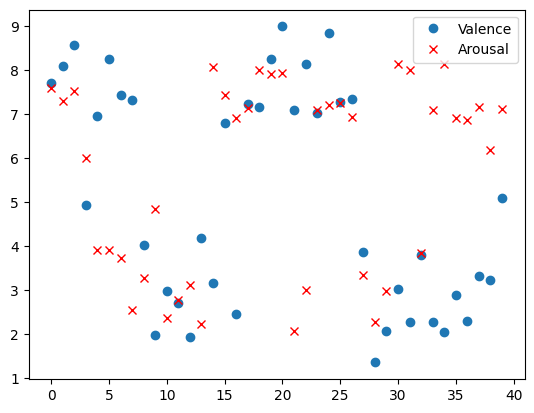

In [9]:
# Plot the first 40 data rows (first participant)
df_label_ratings.iloc[0:40].plot(style=['o','rx'])

In [10]:
# High Arousal Positive Valence dataset
df_hahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Positive Valence dataset
df_lahv = df_label_ratings[(df_label_ratings['Valence'] >= np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]
# High Arousal Negative Valence dataset
df_halv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] >= np.median(labels[:,1]))]
# Low Arousal Negative Valence dataset
df_lalv = df_label_ratings[(df_label_ratings['Valence'] < np.median(labels[:,0])) & (df_label_ratings['Arousal'] < np.median(labels[:,1]))]

In [11]:
# Check nummber of trials per each group
print("Positive Valence:", str(len(df_hahv) + len(df_lahv)))
print("Negative Valence:", str(len(df_halv) + len(df_lalv)))
print("High Arousal:", str(len(df_hahv) + len(df_halv)))
print("Low Arousal:", str(len(df_lahv) + len(df_lalv)))

Positive Valence: 680
Negative Valence: 600
High Arousal: 640
Low Arousal: 640


In [12]:
# Check nummber of trials per each group
print("High Arousal Positive Valence:", str(len(df_hahv)))
print("Low Arousal Positive Valence:", str(len(df_lahv)))
print("High Arousal Negative Valence:", str(len(df_halv)))
print("Low Arousal Negative Valence:", str(len(df_lalv)))

High Arousal Positive Valence: 358
Low Arousal Positive Valence: 322
High Arousal Negative Valence: 282
Low Arousal Negative Valence: 318


In [13]:
# Get mean and std of each group
print("HAHV")
print("Valence:", "Mean", np.round(df_hahv['Valence'].mean(),2), "STD", np.round(df_hahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_hahv['Arousal'].mean(),2), "STD", np.round(df_hahv['Arousal'].std(),2))
print()
print("LAHV:")
print("Valence:", "Mean", np.round(df_lahv['Valence'].mean(),2), "STD", np.round(df_lahv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lahv['Arousal'].mean(),2), "STD", np.round(df_lahv['Arousal'].std(),2))
print()
print("HALV:")
print("Valence:", "Mean", np.round(df_halv['Valence'].mean(),2), "STD", np.round(df_halv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_halv['Arousal'].mean(),2), "STD", np.round(df_halv['Arousal'].std(),2))
print()
print("LALV:")
print("Valence:", "Mean", np.round(df_lalv['Valence'].mean(),2), "STD", np.round(df_lalv['Valence'].std(),2))
print("Arousal:", "Mean", np.round(df_lalv['Arousal'].mean(),2), "STD", np.round(df_lalv['Arousal'].std(),2))

HAHV
Valence: Mean 7.23 STD 1.03
Arousal: Mean 6.87 STD 0.87

LAHV:
Valence: Mean 6.59 STD 1.1
Arousal: Mean 3.83 STD 1.17

HALV:
Valence: Mean 3.11 STD 1.25
Arousal: Mean 6.8 STD 0.97

LALV:
Valence: Mean 3.59 STD 1.19
Arousal: Mean 3.12 STD 1.32


{'whiskers': [<matplotlib.lines.Line2D at 0x7f0fd77a1c90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0fd77a21d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0fd77a19f0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f0fd77a2710>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0fd77a29b0>,
 'means': []}

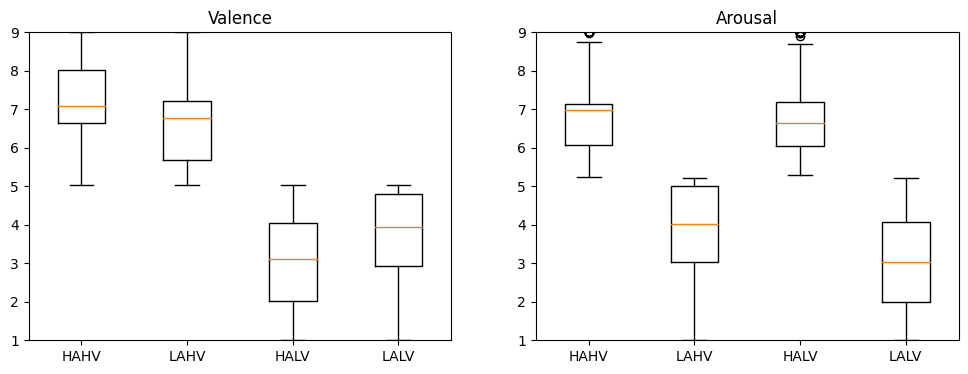

In [14]:
# Valence and Arousal ratings between groups
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].set_title("Valence")
axs[0].set_ylim(1, 9)
axs[0].boxplot([df_hahv['Valence'], df_lahv['Valence'], df_halv['Valence'], df_lalv['Valence']], labels=['HAHV','LAHV','HALV', 'LALV'])

axs[1].set_title("Arousal")
axs[1].set_ylim(1, 9)
axs[1].boxplot([df_hahv['Arousal'], df_lahv['Arousal'], df_halv['Arousal'], df_lalv['Arousal']], labels=['HAHV','LAHV','HALV', 'LALV'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0fd75a3670>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0fd75a3bb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0fd75a33d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f0fd75dc130>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0fd75dc3d0>,
 'means': []}

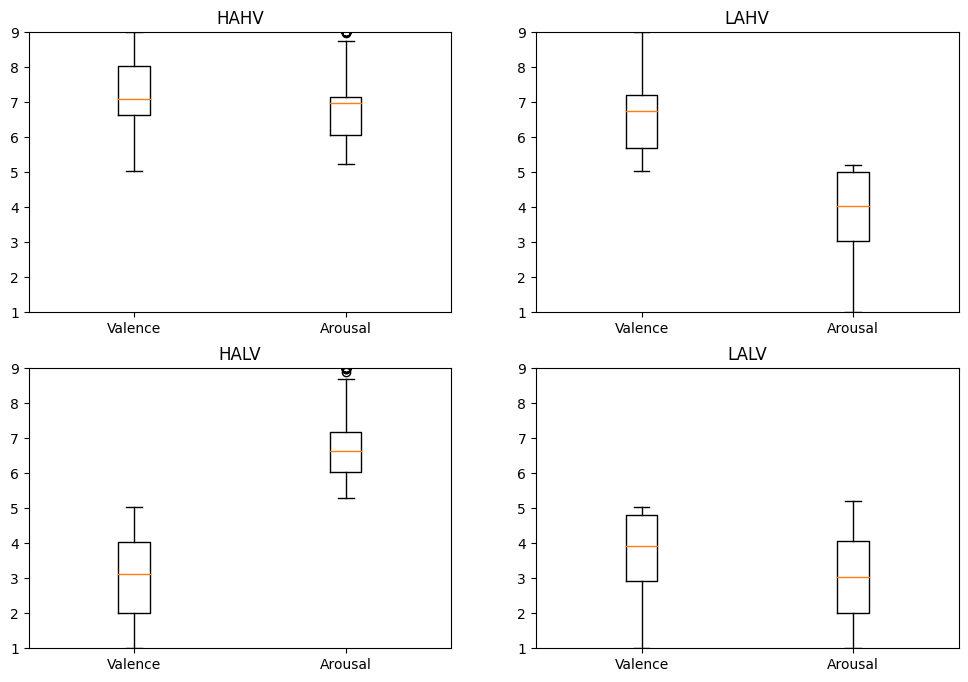

In [15]:
# Valence and Arousal ratings per group
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].set_title("HAHV")
axs[0,0].set_ylim(1, 9)
axs[0,0].boxplot([df_hahv['Valence'], df_hahv['Arousal']], labels=['Valence','Arousal'])

axs[0,1].set_title("LAHV")
axs[0,1].set_ylim(1, 9)
axs[0,1].boxplot([df_lahv['Valence'], df_lahv['Arousal']], labels=['Valence','Arousal'])

axs[1,0].set_title("HALV")
axs[1,0].set_ylim(1, 9)
axs[1,0].boxplot([df_halv['Valence'], df_halv['Arousal']], labels=['Valence','Arousal'])

axs[1,1].set_title("LALV")
axs[1,1].set_ylim(1, 9)
axs[1,1].boxplot([df_lalv['Valence'], df_lalv['Arousal']], labels=['Valence','Arousal'])

In [16]:
# Function to check if each trial has positive or negative valence
def positive_valence(trial):
    return 1 if labels[trial,0] >= np.median(labels[:,0]) else 0 
# Function to check if each trial has high or low arousal
def high_arousal(trial):
    return 1 if labels[trial,1] >= np.median(labels[:,1]) else 0

In [17]:
# Convert all ratings to boolean values
labels_encoded = []
for i in range (len(labels)):
  labels_encoded.append([positive_valence(i), high_arousal(i)])
labels_encoded = np.reshape(labels_encoded, (1280, 2))
df_labels = pd.DataFrame(data=labels_encoded, columns=["Positive Valence", "High Arousal"])
print(df_labels.describe())

       Positive Valence  High Arousal
count       1280.000000   1280.000000
mean           0.531250      0.500000
std            0.499218      0.500195
min            0.000000      0.000000
25%            0.000000      0.000000
50%            1.000000      0.500000
75%            1.000000      1.000000
max            1.000000      1.000000


In [18]:
# Dataset with only Valence column
df_valence = df_labels['Positive Valence']
# Dataset with only Arousal column
df_arousal = df_labels['High Arousal']

In [19]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [20]:
eeg_data = []
for i in range (len(data)):
  for j in range (len(eeg_channels)):
    eeg_data.append(data[i,j])
eeg_data = np.reshape(eeg_data, (len(data), len(eeg_channels), len(data[0,0])))
print(eeg_data.shape)

(1280, 32, 8064)


In [21]:
peripheral_data = []
for i in range (len(data)):
  for j in range (32,len(data[0])):
    peripheral_data.append(data[i,j])
peripheral_data = np.reshape(peripheral_data, (len(data), len(peripheral_channels), len(data[0,0])))
print(peripheral_data.shape)

(1280, 8, 8064)


In [22]:
info = mne.create_info(32, sfreq=128)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 32 MISC
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [23]:
info = mne.create_info(eeg_channels.tolist(), ch_types=32*['eeg'], sfreq=128)
info.set_montage('standard_1020')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [24]:
raw_data = mne.io.RawArray(eeg_data[31], info)

Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.


Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


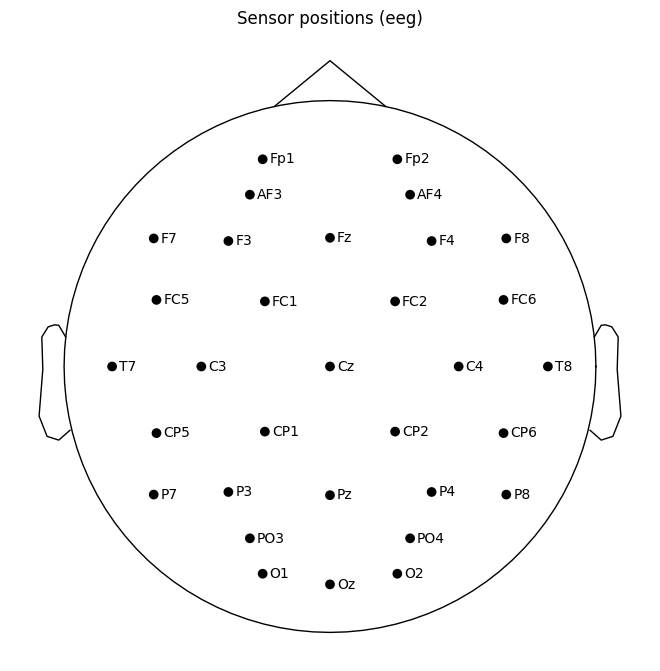

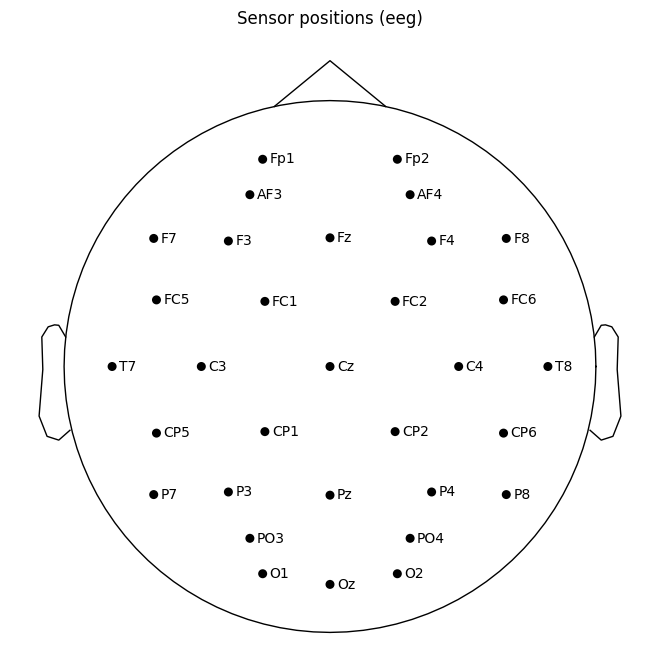

In [25]:
# Plot sensor positions
montage = mne.channels.make_standard_montage("biosemi32")
raw_data.set_montage(montage)
montage.plot()

Effective window size : 16.000 (s)


TypeError: ignored

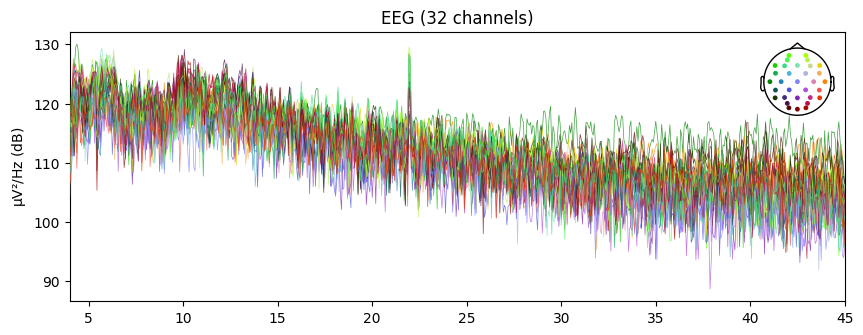

In [26]:
# Plot the power spectral density across channels
mne.viz.plot_raw_psd(raw_data, fmin = 4, fmax= 45)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.10/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.10/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: Deprecatio

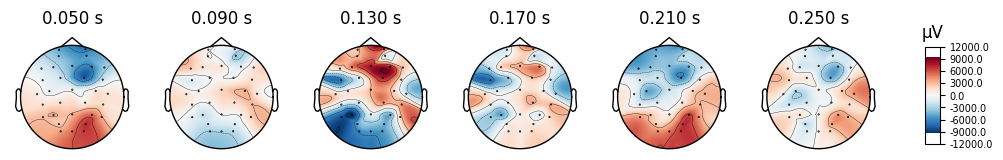

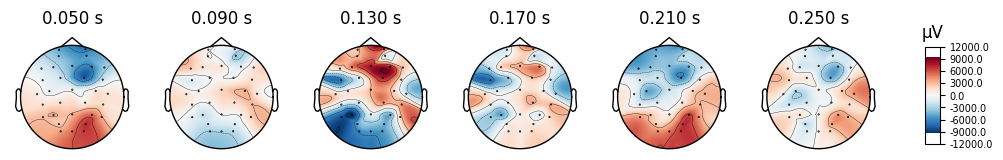

In [27]:
# Theta band, first trial
evData_th = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_th.filter(4, 8) 
evData_th.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.10/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.10/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: Deprecatio

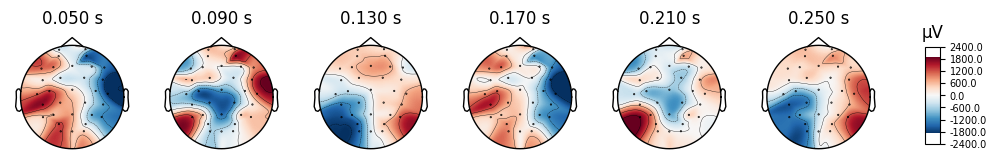

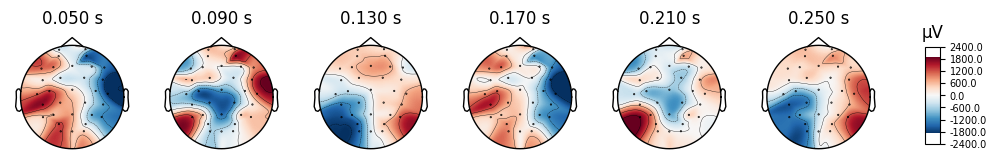

In [28]:
# Alpha band, first trial
evData_al = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_al.filter(8, 12) 
evData_al.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 12 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 141 samples (1.102 sec)



/usr/local/lib/python3.10/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.10/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: Deprecatio

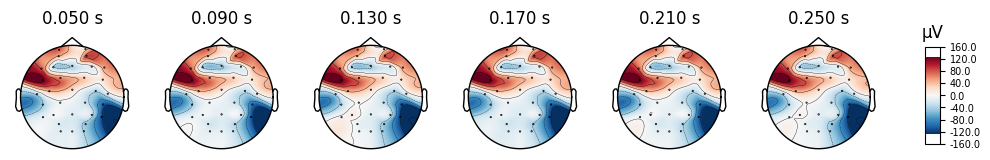

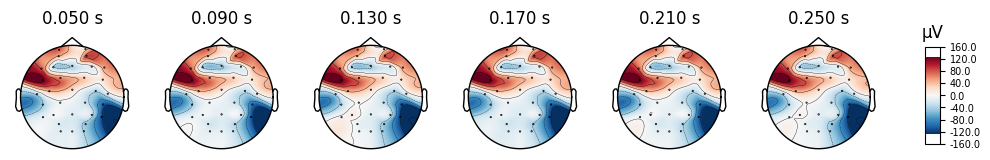

In [29]:
# Beta band, first trial
evData_bt = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_bt.filter(12, 30) 
evData_bt.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 30 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 63.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 63.95 Hz)
- Filter length: 4225 samples (33.008 sec)



/usr/local/lib/python3.10/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.10/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: Deprecatio

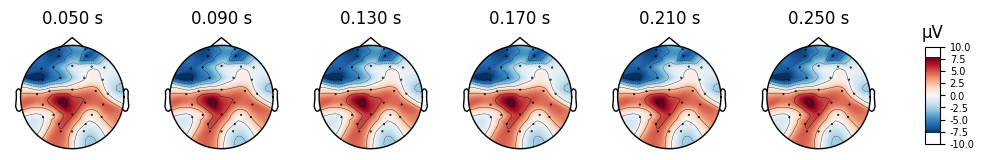

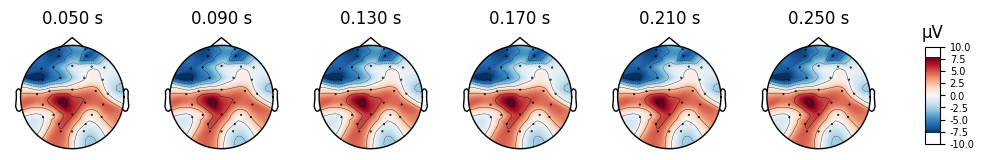

In [30]:
# Gamma band, first trial
evData_gm = mne.EvokedArray(eeg_data[0], info)
times = np.arange(0.05, 0.251, 0.04)
evData_gm.filter(30, 63.9) 
evData_gm.plot_topomap(times, ch_type='eeg', average=60, time_unit='s')

In [31]:
# Getting samples from 4 label groups, same subject
ev_data_hahv = mne.EvokedArray(eeg_data[1], info)
ev_data_halv = mne.EvokedArray(eeg_data[14], info)
ev_data_lahv = mne.EvokedArray(eeg_data[6], info)
ev_data_lalv = mne.EvokedArray(eeg_data[9], info)

In [32]:
# Plot the topographies across different frequency bands
def plot_topo_psd(evData):
  evData.filter(4, 8) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(8, 12) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(12, 30) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

  evData.filter(30, 63.9) 
  evData.plot_topomap(0.15, ch_type='eeg', average=60, time_unit='s')

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.10/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.10/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


AttributeError: ignored

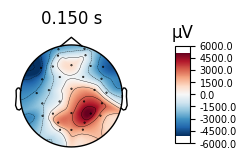

In [39]:
plot_topo_psd(ev_data_hahv)

Setting up band-pass filter from 4 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 213 samples (1.664 sec)



/usr/local/lib/python3.10/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.10/dist-packages/mne/filter.py:313: DeprecationWarning: Keyword argument 'nyq' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  this_h = firwin(this_N, (prev_freq + this_freq) / 2.,
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


AttributeError: ignored

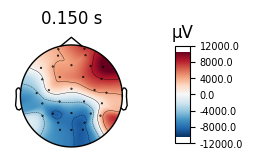

In [35]:
plot_topo_psd(ev_data_halv)

In [40]:
# Deal with NaN values when the model cannot detect peaks in any given range
def check_nans(data, nan_policy='zero'):
    """Check an array for nan values, and replace, based on policy."""
    # Find where there are nan values in the data
    nan_inds = np.where(np.isnan(data))
    # Apply desired nan policy to data
    if nan_policy == 'zero':
        data[nan_inds] = 0
    elif nan_policy == 'mean':
        data[nan_inds] = np.nanmean(data)
    else:
        raise ValueError('Nan policy not understood.')
    return data

In [41]:
# Plot the topographies across different frequency bands
def plot_psd_fooof(evData):
  fg = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.05, peak_threshold=2., max_n_peaks=6, verbose=False)
  bands = Bands({'theta': [4, 8],'alpha': [8, 12],'beta': [12, 30],'gamma': [30, 64]})
  freq_range = [1, 128]
  # Calculate power spectra across the the continuous data by MNE
  spectra, freqs = psd_welch(evData, fmin=1, fmax=128, tmin=0, tmax=250, n_overlap=150, n_fft=300)
  fg.fit(freqs, spectra, freq_range)
  # Plot the topographies across different frequency bands
  fig, axes = plt.subplots(1, 4, figsize=(20, 5))
  for ind, (label, band_def) in enumerate(bands):
      # Extract the power peaks across channels for the current band
      band_power = check_nans(get_band_peak_fg(fg, band_def)[:, 1])
      # Create a topomap for the current oscillation band
      mne.viz.plot_topomap(band_power, evData.info, cmap=cm.viridis, axes=axes[ind], show=False);
      axes[ind].set_title(label + ' power', {'fontsize' : 16})

In [42]:
def plot_psd_peak(evData):
  fg = FOOOFGroup(peak_width_limits=[1, 6], min_peak_height=0.05, peak_threshold=2., max_n_peaks=6, verbose=False)
  bands = Bands({'theta': [4, 8],'alpha': [8, 12],'beta': [12, 30],'gamma': [30, 64]})
  freq_range = [1, 128]
  # Calculate power spectra across the the continuous data by MNE
  spectra, freqs = psd_welch(evData, fmin=1, fmax=128, tmin=0, tmax=250, n_overlap=150, n_fft=300)
  fg.fit(freqs, spectra, freq_range)
  # Check the largest detected peaks within each band
  fig, axes = plt.subplots(1, 4, figsize=(20, 6))
  for ind, (label, band_def) in enumerate(bands):
      # Get the power values across channels for the current band
      band_power = check_nans(get_band_peak_fg(fg, band_def)[:, 1])
      # Extracted and plot the power spectrum model with the most band power
      fg.get_fooof(np.argmax(band_power)).plot(ax=axes[ind], add_legend=False)
      axes[ind].yaxis.set_ticklabels([])
      axes[ind].set_title('biggest ' + label + ' peak', {'fontsize' : 16})

Effective window size : 2.344 (s)


/usr/local/lib/python3.10/dist-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr

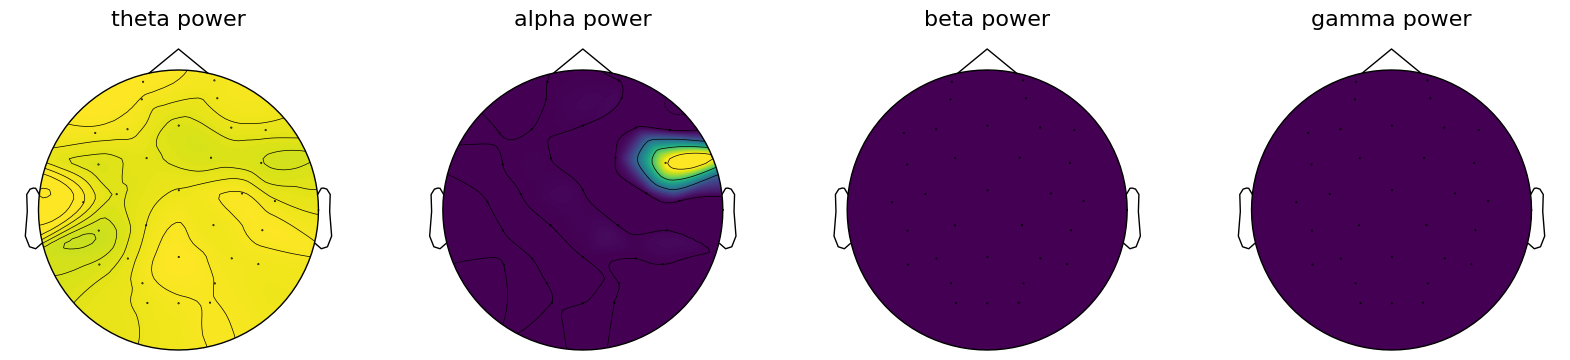

In [43]:
plot_psd_fooof(ev_data_hahv)

Effective window size : 2.344 (s)


/usr/local/lib/python3.10/dist-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


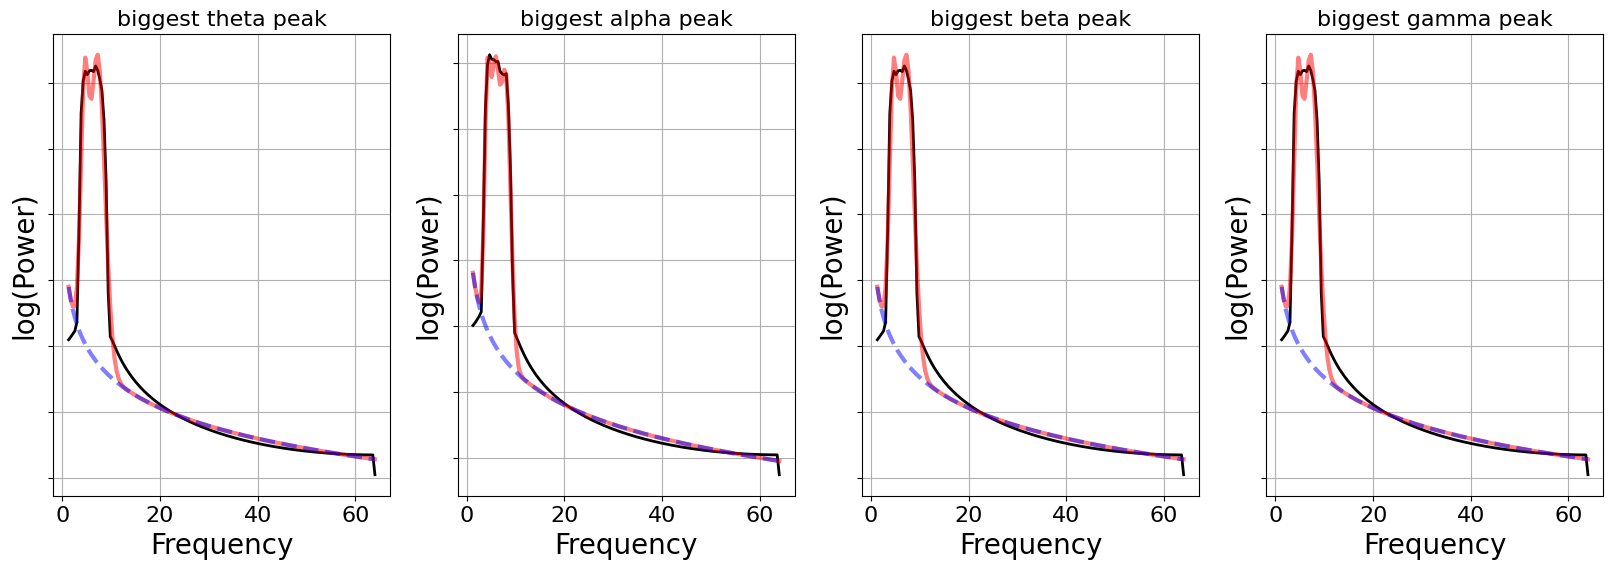

In [44]:
plot_psd_peak(ev_data_hahv)

Effective window size : 2.344 (s)


/usr/local/lib/python3.10/dist-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr

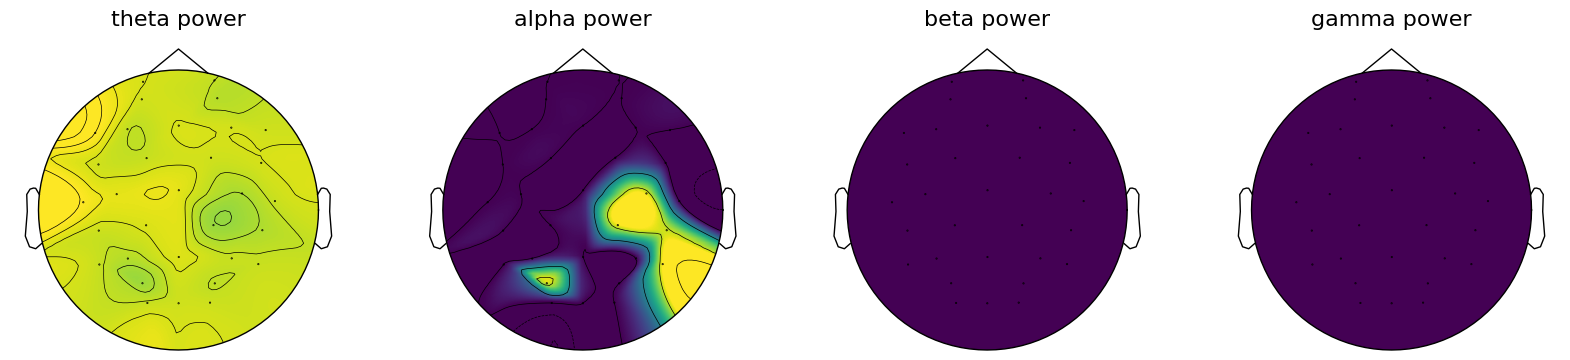

In [45]:
plot_psd_fooof(ev_data_halv)

Effective window size : 2.344 (s)


/usr/local/lib/python3.10/dist-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


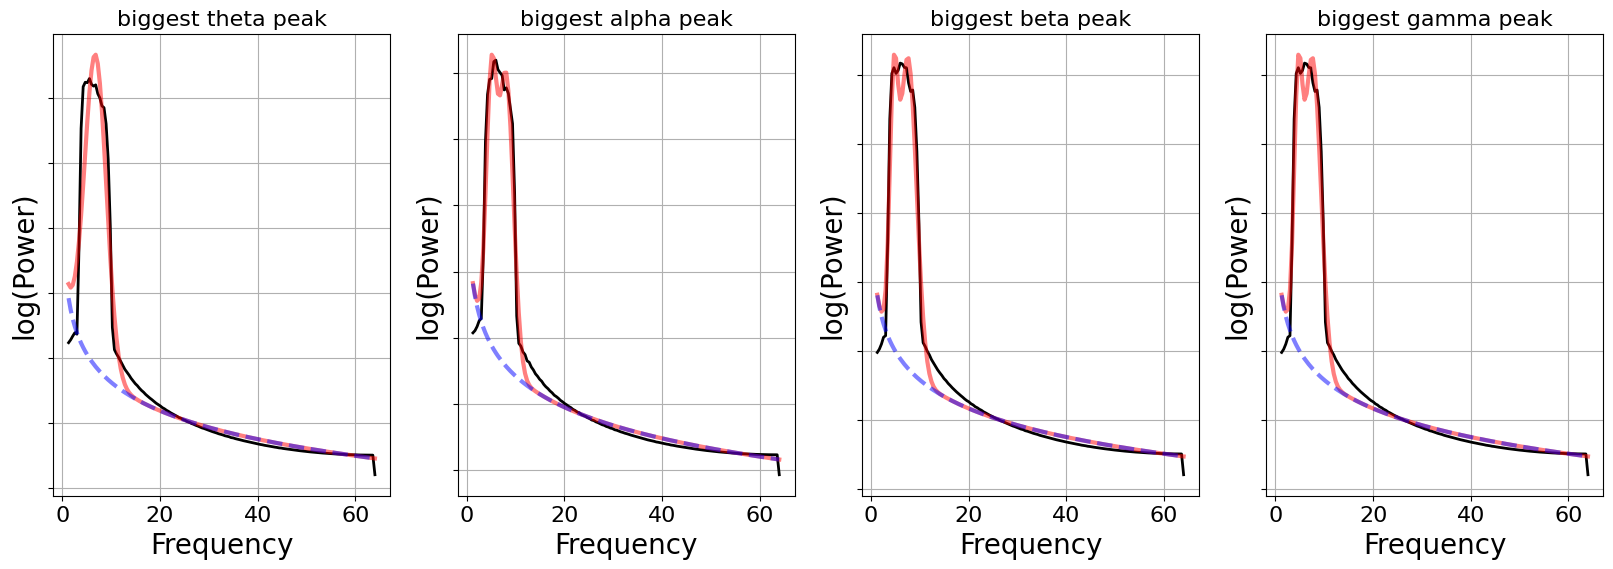

In [46]:
plot_psd_peak(ev_data_halv)

Effective window size : 2.344 (s)


/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


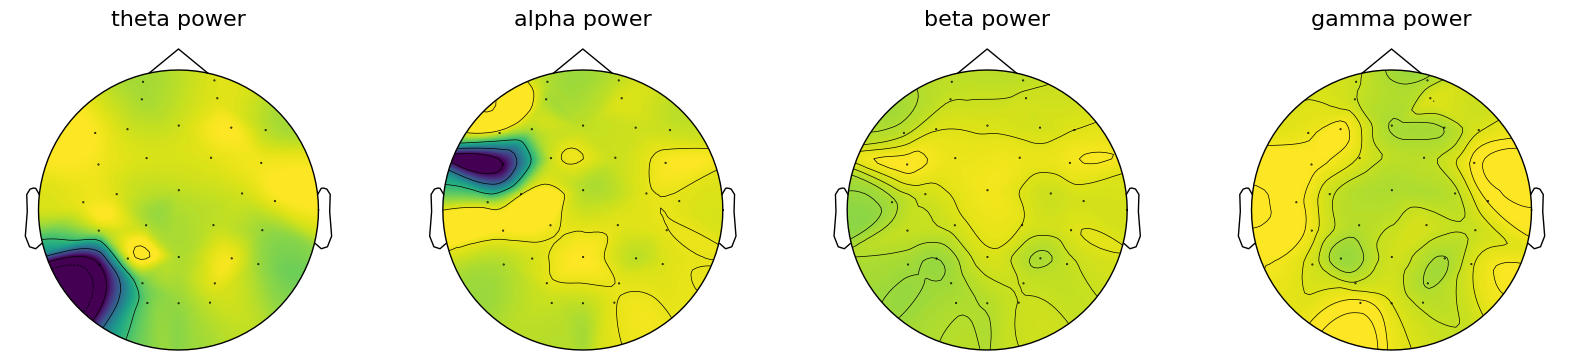

In [47]:
plot_psd_fooof(ev_data_lahv)

Effective window size : 2.344 (s)


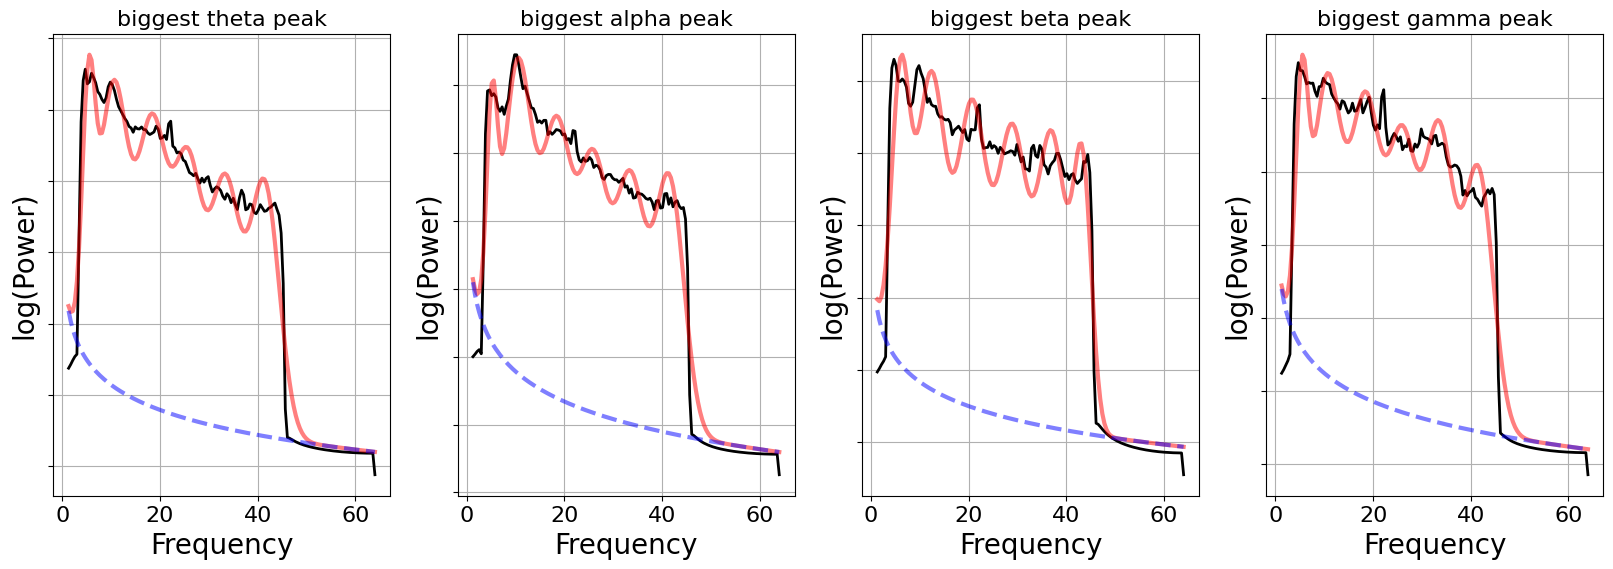

In [48]:

plot_psd_peak(ev_data_lahv)

Effective window size : 2.344 (s)


/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:463: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


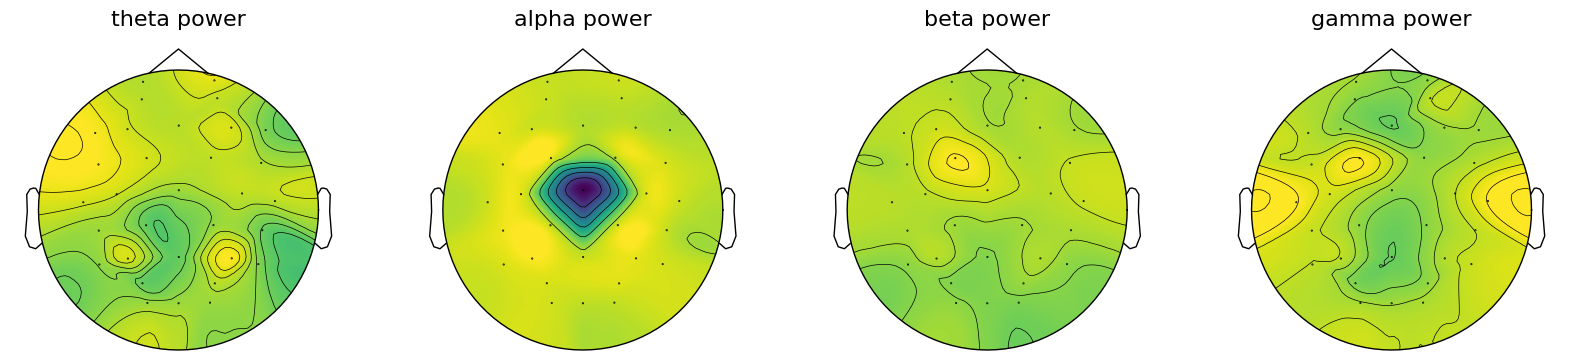

In [49]:
plot_psd_fooof(ev_data_lalv)

Effective window size : 2.344 (s)


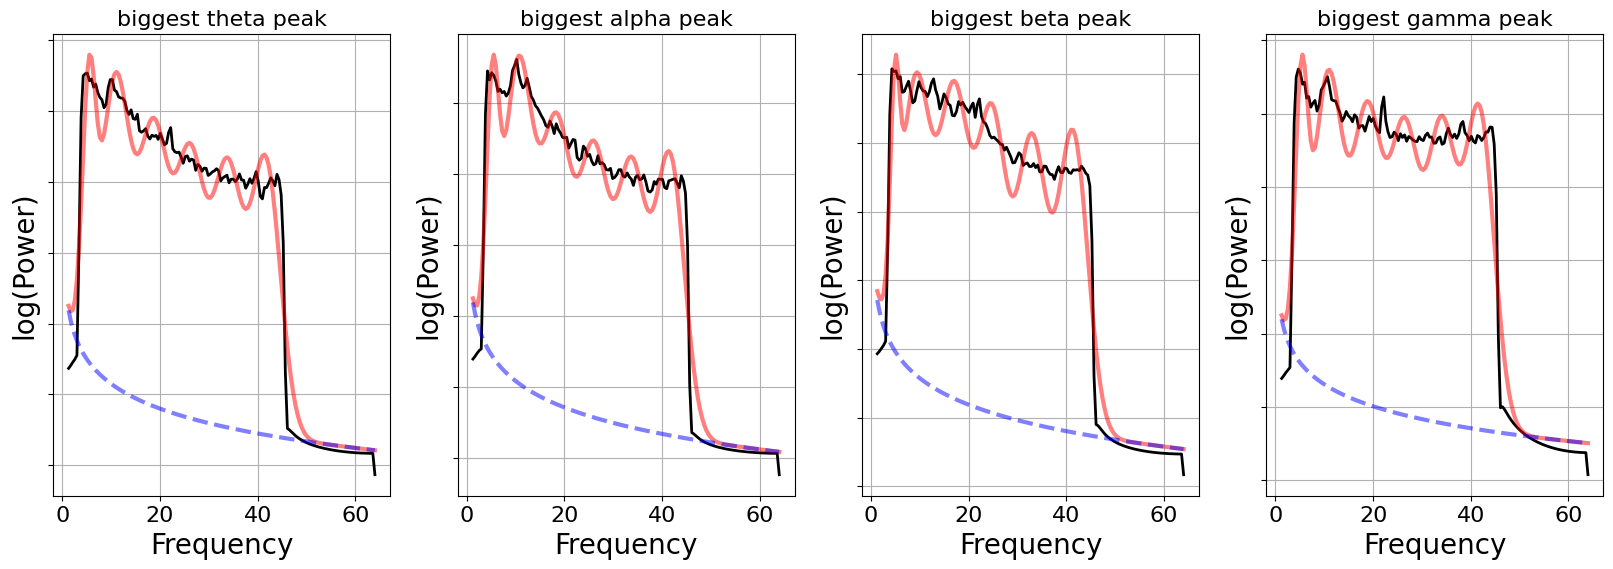

In [50]:
plot_psd_peak(ev_data_lalv)

In [52]:
left = np.array(["Fp1", "AF3", "F7", "FC5", "T7"])
right = np.array(["Fp2", "AF4", "F8", "FC6", "T8"])
frontal = np.array(["F3", "FC1", "Fz", "F4", "FC2"])
parietal = np.array(["P3", "P7", "Pz", "P4", "P8"])
occipital = np.array(["O1", "Oz", "O2", "PO3", "PO4"])
central = np.array(["CP5", "CP1", "Cz", "C4", "C3", "CP6", "CP2"])

In [53]:
# Transform 880 x 32 x 8064 => 880 x 32 
eeg_theta = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_theta.append(get_band_power(i,j,"theta"))
eeg_theta = np.reshape(eeg_theta, (1280, 32))

df_theta = pd.DataFrame(data = eeg_theta, columns=eeg_channels)
print(df_theta.describe())

NameError: ignored